In [ ]:
#원본데이터 저장
import os
import requests
import feedparser
from goose3 import Goose
from goose3.text import StopWordsKorean
from urllib.parse import urlparse
from konlpy.tag import Kkma, Hannanum
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import normalize
from datetime import datetime

def get_data(url):
    try:
        res = requests.get(url)
        html = res.text
        data = feedparser.parse(html)
        print(data.feed.title)
        return data
    except:
        return None

def summarize_article(article_content):
    kkma = Kkma()
    sentences = kkma.sentences(article_content)

    def get_nouns(sentences):
        nouns = []
        for sentence in sentences:
            if sentence != '':
                nouns.append(' '.join([noun for noun in hannanum.nouns(str(sentence))
                                       if noun not in stopwords and len(noun) > 1]))
        return nouns

    #불용어제거
    hannanum = Hannanum()
    stopwords = []
    with open('/Users/yurim/Desktop/실습/stopwords.txt', 'r', encoding='utf-8') as f:
        stopwords = f.read().split(",")

    nouns = get_nouns(sentences)

    #TF-IDF Count Vectorizer 기반 그래프 생성(문장/단어)
    tfidf = TfidfVectorizer()
    cnt_vec = CountVectorizer()

    def build_sent_graph(sentence):
        tfidf_mat = tfidf.fit_transform(sentence).toarray()
        graph_sentence = np.dot(tfidf_mat, tfidf_mat.T)
        return graph_sentence

    def build_words_graph(sentence):
        cnt_vec_mat = normalize(cnt_vec.fit_transform(sentence).toarray().astype(float), axis=0)
        vocab = cnt_vec.vocabulary_
        return np.dot(cnt_vec_mat.T, cnt_vec_mat), {vocab[word]: word for word in vocab}

    sent_graph = build_sent_graph(nouns)
    word_graph, idx2word = build_words_graph(nouns)

    #페이지 랭크계산
    def get_ranks(graph, d=0.85): #dumping factor
        A = graph
        matrix_size = A.shape[0]
        for id in range(matrix_size):
            A[id, id] = 0
            link_sum = np.sum(A[:, id])
            if link_sum != 0:
                A[:, id] /= link_sum
            A[:, id] *= -d
            A[id, id] = 1
        B = (1 - d) * np.ones((matrix_size, 1))
        ranks = np.linalg.solve(A, B) #Ax = b
        return {idx: r[0] for idx, r in enumerate(ranks)}

    sent_rank_idx = get_ranks(sent_graph)
    sorted_sent_rank_idx = sorted(sent_rank_idx, key=lambda k: sent_rank_idx[k], reverse=True)

    word_rank_idx = get_ranks(word_graph)
    sorted_word_rank_idx = sorted(word_rank_idx, key=lambda k: word_rank_idx[k], reverse=True)

    #요약/키워드 추출
    def summarize(sent_num=3):
        summary = []
        index = []
        for idx in sorted_sent_rank_idx[:sent_num]:
            index.append(idx)
        index.sort()

        for idx in index:
            summary.append(sentences[idx])

        return summary

    def keywords(word_num=10):
        keywords = []
        index = []
        for idx in sorted_word_rank_idx[:word_num]:
            index.append(idx)

        for idx in index:
            keywords.append(idx2word[idx])

        return ', '.join(keywords)

    summarized = summarize()
    keyword_str = keywords()

    return summarized, keyword_str

url = "http://www.khan.co.kr/rss/rssdata/total_news.xml"

parsed_data = get_data(url)

read = Goose({'stopwords_class': StopWordsKorean})

output_directory = "news_data"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

file_number_dict = {}

for i in parsed_data.entries:
    title = i.title
    link = i.link
    date = i.updated

    url = i.link
    article = read.extract(url=url)
    content = article.cleaned_text

    date_str = datetime.strptime(date.split("+")[0], "%Y-%m-%dT%H:%M:%S")
    date_str_name = date.split("T")[0]

    parsed_url = urlparse(link)
    path_parts = parsed_url.path.split("/")
    keyword = path_parts[1]

    sub_directory = os.path.join(output_directory, date_str_name)
    if not os.path.exists(sub_directory):
        os.makedirs(sub_directory)

    if keyword not in file_number_dict:
        file_number_dict[keyword] = {}
    if date_str_name not in file_number_dict[keyword]:
        file_number_dict[keyword][date_str_name] = 1
    else:
        file_number_dict[keyword][date_str_name] += 1

    file_number = file_number_dict[keyword][date_str_name]

    file_name = os.path.join(sub_directory, f"{keyword}_{file_number}.txt")

    with open(file_name, 'w', encoding='utf-8') as file:
        file.write(f"Title: {title}\n")
        file.write(f"Link: {link}\n")
        file.write(f"Date: {date_str}\n")
        file.write(f"Keyword: {keyword}\n")
        file.write(f"Content: \n{content}\n\n")

    print(f"기사 '{title}'를 '{date_str_name}/{keyword}_{file_number}.txt' 파일로 저장했습니다.")

In [ ]:
#summary 실행 코드
def get_data(url):
    try:
        res = requests.get(url)
        html = res.text
        data = feedparser.parse(html)
        print(data.feed.title)
        return data
    except:
        return None

def summarize_article(article_content):
    kkma = Kkma()
    sentences = kkma.sentences(article_content)

    def get_nouns(sentences):
        nouns = []
        for sentence in sentences:
            if sentence != '':
                nouns.append(' '.join([noun for noun in hannanum.nouns(str(sentence))
                                       if noun not in stopwords and len(noun) > 1]))
        return nouns

    hannanum = Hannanum()
    stopwords = []
    with open('/Users/yurim/Desktop/실습/stopwords.txt', 'r', encoding='utf-8') as f:
        stopwords = f.read().split(",")

    nouns = get_nouns(sentences)

    tfidf = TfidfVectorizer()
    cnt_vec = CountVectorizer()

    def build_sent_graph(sentence):
        tfidf_mat = tfidf.fit_transform(sentence).toarray()
        graph_sentence = np.dot(tfidf_mat, tfidf_mat.T)
        return graph_sentence

    def build_words_graph(sentence):
        cnt_vec_mat = normalize(cnt_vec.fit_transform(sentence).toarray().astype(float), axis=0)
        vocab = cnt_vec.vocabulary_
        return np.dot(cnt_vec_mat.T, cnt_vec_mat), {vocab[word]: word for word in vocab}

    sent_graph = build_sent_graph(nouns)
    word_graph, idx2word = build_words_graph(nouns)

    def get_ranks(graph, d=0.85):
        A = graph
        matrix_size = A.shape[0]
        for id in range(matrix_size):
            A[id, id] = 0
            link_sum = np.sum(A[:, id])
            if link_sum != 0:
                A[:, id] /= link_sum
            A[:, id] *= -d
            A[id, id] = 1
        B = (1 - d) * np.ones((matrix_size, 1))
        ranks = np.linalg.solve(A, B)
        return {idx: r[0] for idx, r in enumerate(ranks)}

    sent_rank_idx = get_ranks(sent_graph)
    sorted_sent_rank_idx = sorted(sent_rank_idx, key=lambda k: sent_rank_idx[k], reverse=True)

    word_rank_idx = get_ranks(word_graph)
    sorted_word_rank_idx = sorted(word_rank_idx, key=lambda k: word_rank_idx[k], reverse=True)

    def summarize(sent_num=3):
        summary = []
        index = []
        for idx in sorted_sent_rank_idx[:sent_num]:
            index.append(idx)
        index.sort()

        for idx in index:
            summary.append(sentences[idx])

        return summary

    def keywords(word_num=10):
        keywords = []
        index = []
        for idx in sorted_word_rank_idx[:word_num]:
            index.append(idx)

        for idx in index:
            keywords.append(idx2word[idx])

        return ', '.join(keywords)

    summarized = summarize()
    keyword_list = keywords()

    return summarized, keyword_list

url = "http://www.khan.co.kr/rss/rssdata/total_news.xml"

parsed_data = get_data(url)

read = Goose({'stopwords_class': StopWordsKorean})

output_summary_directory = "news_data_summary"
if not os.path.exists(output_summary_directory):
    os.makedirs(output_summary_directory)

file_list = []

for root, dirs, files in os.walk(output_directory):
    for file in files:
        if file.endswith(".txt"):
            file_list.append(os.path.join(root, file))

for article_file in file_list:
    with open(article_file, 'r', encoding='utf-8') as file:
        file_content = file.read()

        file_content = re.sub(r'Title:.*\n', '', file_content)
        file_content = re.sub(r'Date:.*\n', '', file_content)
        file_content = re.sub(r'Keyword:.*\n', '', file_content)

        link_start = file_content.find("Link: ")
        if link_start != -1:
            link_end = file_content.find('\n', link_start)
            link = file_content[link_start + 6:link_end]

        summarized, keyword_list = summarize_article(file_content)
        #summarized = [s for s in summarized if not s.startswith("Content:")]

        original_filename = os.path.basename(article_file)

        date_str = article_file.split(os.sep)[-2]

        result_dir = os.path.join(output_summary_directory, date_str)
        if not os.path.exists(result_dir):
            os.makedirs(result_dir)

        result_file_path = os.path.join(result_dir, original_filename)

        with open(result_file_path, "w", encoding="utf-8") as result_file:
            result_file.write("Link: {}\n".format(link))
            result_file.write("Summary:\n")
            for sentence in summarized:
                result_file.write(f"{sentence}\n")
            result_file.write("\nKeywords:\n")
            result_file.write(keyword_list + '\n')
            result_file.write("\n")

        print(f"기사 '{original_filename}'를 '{output_summary_directory}/{original_filename}'에 저장했습니다.")

In [ ]:
#원본데이터 DB저장
import pymysql
import os
conn = pymysql.connect(
    host='127.0.0.1',
    user='root',
    password='10044085',
    db='db_1',
    charset='utf8mb4'
)
def article_exists(link):
    try:
        with conn.cursor() as cursor:
            sql = "SELECT COUNT(*) FROM crawl_db WHERE news_link = %s"
            cursor.execute(sql, (link,))
            result = cursor.fetchone()
            return result[0] > 0
    except Exception as e:
        print(f"데이터베이스 확인 중 오류 발생: {e}")
        return False

def save_to_database(title, link, date_str, keyword, content):
    try:
        with conn.cursor() as cursor:
            if article_exists(link):
                sql = "UPDATE crawl_db SET news_title = %s, news_date = %s, news_keyword = %s, news_content = %s WHERE news_link = %s"
                cursor.execute(sql, (title, date_str, keyword, content, link))
            else:
                if title is not None and link is not None and date_str is not None and keyword is not None and content is not None:
                    sql = "INSERT INTO crawl_db (news_title, news_link, news_date, news_keyword, news_content) VALUES (%s, %s, %s, %s, %s)"
                    cursor.execute(sql, (title, link, date_str, keyword, content))
            conn.commit()
    except Exception as e:
        print(f"데이터베이스 저장 중 오류 발생: {e}")
        conn.rollback()


news_data_directory = "news_data"

for root, dirs, files in os.walk(news_data_directory):
    for file in files:
        if file.endswith(".txt"):
            file_path = os.path.join(root, file)
            with open(file_path, 'r', encoding='utf-8') as txt_file:
                file_content = txt_file.read()
                title_start = file_content.find("Title:")
                link_start = file_content.find("Link:")
                date_start = file_content.find("Date:")
                keyword_start = file_content.find("Keyword:")
                content_start = file_content.find("Content:")

                title = file_content[title_start + len("Title:"):link_start].strip()
                link = file_content[link_start + len("Link:"):date_start].strip()
                date_str = file_content[date_start + len("Date:"):keyword_start].strip()
                keyword = file_content[keyword_start + len("Keyword:"):content_start].strip()
                content = file_content[content_start + len("Content:"):].strip()

                save_to_database(title, link, date_str, keyword, content)
                print(f"{file_path}을 데이터베이스에 저장했습니다.")

conn.close()

In [ ]:
#요약데이터 DB저장
import pymysql
conn = pymysql.connect(
    host='127.0.0.1',
    user='root',
    password='10044085',
    db='db_1',
    charset='utf8mb4'
)

def save_to_database(link, summary, keywords):
    try:
        with conn.cursor() as cursor:
            sql = "SELECT * FROM summary_db WHERE news_link = %s"
            cursor.execute(sql, (link,))
            existing_data = cursor.fetchone()

            if existing_data:
                sql = "UPDATE summary_db SET news_summary = %s, news_keywords = %s WHERE news_link = %s"
                cursor.execute(sql, (summary, keywords, link))
            else:
                sql = "INSERT INTO summary_db (news_link, news_summary, news_keywords) VALUES (%s, %s, %s)"
                cursor.execute(sql, (link, summary, keywords))
            conn.commit()
    except Exception as e:
        print(f"데이터베이스 저장 중 오류 발생: {e}")
        conn.rollback()

news_data_summary_directory = "news_data_summary"

for root, dirs, files in os.walk(news_data_summary_directory):
    for file in files:
        if file.endswith(".txt"):
            file_path = os.path.join(root, file)
            with open(file_path, 'r', encoding='utf-8') as txt_file:
                file_contents = txt_file.read()
                link_start = file_contents.find("Link:")
                summary_start = file_contents.find("Summary:")
                keywords_start = file_contents.find("Keywords:")

                link = file_contents[link_start + len("Link:"):summary_start].strip()
                summary = file_contents[summary_start + len("Summary:"):keywords_start].strip()
                keywords = file_contents[keywords_start + len("Keywords:"):].strip()

                save_to_database(link, summary, keywords)
                print(f"{file_path}을 데이터베이스에 저장했습니다.")

conn.close()

In [ ]:
summary_folder = 'news_data_summary'

file_count = 0

for root, dirs, files in os.walk(summary_folder):
    for file in files:
        if file.endswith(".txt"):
            file_count += 1

print(f"'news_data_summary' 폴더 내의 데이터 개수: {file_count} 개")

'news_data_summary' 폴더 내의 데이터 개수: 3413 개


In [ ]:
original_folder = 'news_data'

file_count = 0

for root, dirs, files in os.walk(original_folder):
    for file in files:
        if file.endswith(".txt"):
            file_count += 1

print(f"'news_data' 폴더 내의 데이터 개수: {file_count} 개")

'news_data' 폴더 내의 데이터 개수: 3413 개


In [ ]:
import os
import re

search_directory = "news_data_summary"

def find_files_with_special_characters(directory):
    special_characters_pattern = re.compile(r'[!@#$%^&*()_+={}\[\];\<>?/\\|`~]')

    files_with_special_characters = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".txt"):
                with open(os.path.join(root, file), 'r', encoding='utf-8') as file:
                    content = file.read()
                    if special_characters_pattern.search(content):
                        files_with_special_characters.append(file_path)
        return files_with_special_characters

special_character_files = find_files_with_special_characters(search_directory)

if special_character_files:
    print("다음 파일에서 특수문자를 포함하는 내용을 찾았습니다:")
    for file_path in special_character_files:
        print(file_path)
else:
    print("특수문자를 포함하는 내용이 있는 파일을 찾지 못했습니다.")

특수문자를 포함하는 내용이 있는 파일을 찾지 못했습니다.


In [ ]:
news_data_directory = "news_data"

folder_counts = {}

for root, dirs, files in os.walk(news_data_directory):
    for folder in dirs:
        folder_path = os.path.join(root, folder)
        file_count = len([f for f in os.listdir(folder_path) if f.endswith(".txt")])
        folder_counts[folder] = file_count

for folder, count in folder_counts.items():
    print(f"폴더 '{folder}'에 파일 {count}개 있음")

폴더 '2023-10-04'에 파일 171개 있음
폴더 '2023-10-03'에 파일 192개 있음
폴더 '2023-10-05'에 파일 168개 있음
폴더 '2023-10-16'에 파일 252개 있음
폴더 '2023-10-11'에 파일 161개 있음
폴더 '2023-10-18'에 파일 92개 있음
폴더 '2023-10-10'에 파일 269개 있음
폴더 '2023-10-17'에 파일 250개 있음
폴더 '2023-09-24'에 파일 86개 있음
폴더 '2023-09-23'에 파일 48개 있음
폴더 '2023-09-25'에 파일 257개 있음
폴더 '2023-10-09'에 파일 166개 있음
폴더 '2023-10-08'에 파일 157개 있음
폴더 '2023-10-15'에 파일 158개 있음
폴더 '2023-10-14'에 파일 16개 있음
폴더 '2023-10-13'에 파일 186개 있음
폴더 '2023-09-20'에 파일 129개 있음
폴더 '2023-09-18'에 파일 250개 있음
폴더 '2023-09-26'에 파일 161개 있음
폴더 '2023-09-19'에 파일 244개 있음


In [ ]:
news_data_directory = "news_data_summary"

folder_counts = {}

for root, dirs, files in os.walk(news_data_directory):
    for folder in dirs:
        folder_path = os.path.join(root, folder)
        file_count = len([f for f in os.listdir(folder_path) if f.endswith(".txt")])
        folder_counts[folder] = file_count

for folder, count in folder_counts.items():
    print(f"폴더 '{folder}'에 파일 {count}개 있음")

폴더 '2023-10-04'에 파일 171개 있음
폴더 '2023-10-03'에 파일 192개 있음
폴더 '2023-10-05'에 파일 168개 있음
폴더 '2023-10-16'에 파일 252개 있음
폴더 '2023-10-11'에 파일 161개 있음
폴더 '2023-10-18'에 파일 92개 있음
폴더 '2023-10-10'에 파일 269개 있음
폴더 '2023-10-17'에 파일 250개 있음
폴더 '2023-09-24'에 파일 86개 있음
폴더 '2023-09-23'에 파일 48개 있음
폴더 '2023-09-25'에 파일 257개 있음
폴더 '2023-10-09'에 파일 166개 있음
폴더 '2023-10-08'에 파일 157개 있음
폴더 '2023-10-15'에 파일 158개 있음
폴더 '2023-10-14'에 파일 16개 있음
폴더 '2023-10-13'에 파일 186개 있음
폴더 '2023-09-20'에 파일 129개 있음
폴더 '2023-09-18'에 파일 250개 있음
폴더 '2023-09-26'에 파일 161개 있음
폴더 '2023-09-19'에 파일 244개 있음


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
import os

news_data_directory = "news_data"
data = []

for root, dirs, files in os.walk(news_data_directory):
    for file in files:
        if file.endswith(".txt"):
            file_path = os.path.join(root, file)

            with open(file_path, 'r', encoding='utf-8') as file:
                file_content = file.read()
                # 각 항목 추출
                title_start = file_content.find("Title:")
                link_start = file_content.find("Link:")
                date_start = file_content.find("Date:")
                keyword_start = file_content.find("Keyword:")
                content_start = file_content.find("Content:")

                title = file_content[title_start + len("Title:"):link_start].strip()
                link = file_content[link_start + len("Link:"):date_start].strip()
                date = file_content[date_start + len("Date:"):keyword_start].strip()
                keyword = file_content[keyword_start + len("Keyword:"):content_start].strip()
                content = file_content[content_start + len("Content:"):].strip()

                data.append([title, link, date, keyword, content])

df = pd.DataFrame(data, columns=['Title', 'Link', 'Date', 'Keyword', 'Content'])

df

,Title,Link,Date,Keyword,Content
0,‘수서~동탄 20분’ GTX-A 내년 초 개통…사업시행자 운영 협약식,https://www.khan.co.kr/economy/auto/article/20...,2023-10-04 11:15:03,economy,국토교통부가 내년 초 개통을 목표로 추진 중인 GTX-A 수서∼동탄 구간에 대한 운...
1,"대구문화예술진흥원, 20일부터 ‘2023 우리동네 생활문화주간’ 행사 개최",https://www.khan.co.kr/local/Daegu/article/202...,2023-10-04 10:03:01,local,대구문화예술진흥원은 오는 20~24일 ‘우리동네 생활문화주간’ 행사를 개최한다고 4...
2,"공정위, 숏크리트 설비 입찰 담합 3개사에 과징금 1억5900만원 부과",https://www.khan.co.kr/economy/economy-general...,2023-10-04 15:13:00,economy,터널 공사용 장비 입찰에서 담합을 벌인 업체 3곳이 적발돼 공정거래위원회의 제재를 ...
3,"‘세금낭비’ 괴산 대형 가마솥, 국민공모에도 활용방안 못찾아",https://www.khan.co.kr/travel/national/article...,2023-10-04 16:18:00,travel,충북 괴산군 괴산읍 동부리 괴산농산물 유통센터 정자에는 국내 최대 규모의 가마솥이 ...
4,신진서가 말하는 ‘바둑 AG에 있어야 하는 이유’,https://www.khan.co.kr/sports/olympic-asian_ga...,2023-10-04 14:55:00,sports,“오랜 전통과 역사 속에 살아남았다는 것 자체로 바둑이란 게임이 얼마나 재미있는 게...
...,...,...,...,...,...
2967,일주일 만에 또…‘땅 꺼짐 조짐’ 강남 차병원&#8594;교보타워 한때 도로 통제,https://www.khan.co.kr/national/incident/artic...,2023-09-19 17:44:00,national,얼마 전 땅 꺼짐 현상이 발생했던 서울 강남구 언주역 인근에서 또다시 지반이 내려앉...
2968,[안호기 칼럼] 불평등 방치한 국가의 책임과 재정건전성,https://www.khan.co.kr/opinion/column/article/...,2023-09-19 20:31:01,opinion,‘계층 간 갈등을 심화시켜 심각한 사회문제로 번질 수 있다.’ 양극화나 불평등에 관...
2969,과천-동작 20분대 이수-과천 터널 2025년 착공…대관람차 ‘서울링’ 민자사업 적...,https://www.khan.co.kr/economy/economy-general...,2023-09-19 14:43:00,economy,과천시에서 서울 동작구까지 주행시간을 20분대로 단축하는 이수-과천 복합터널 사업이...
2970,"“내 동생 살려 내라”…유족, 옛 애인 살해 스토킹범 엄벌 촉구",https://www.khan.co.kr/economy/market-trend/ar...,2023-09-19 16:11:01,economy,법원의 접근금지 명령을 받고도 직장 상사인 옛 연인을 찾아가 흉기로 살해한 30대 ...


In [ ]:
news_data_directory = "news_data"

article_contents = []

for root, dirs, files in os.walk(news_data_directory):
    for file in files:
        if file.endswith(".txt"):
            file_path = os.path.join(root, file)

            with open(file_path, 'r', encoding='utf-8') as file:
                file_content = file.read()
                article_contents.append(file_content)

In [ ]:
#DBSCAN
tfidf_vectorizer = TfidfVectorizer(min_df=3, ngram_range=(1,5))
tfidf_vectorizer.fit(article_contents)
vector = tfidf_vectorizer.transform(article_contents).toarray()

vector = np.array(vector)
model = DBSCAN(eps=0.5, min_samples=1, metric="cosine")
result = model.fit_predict(vector)


In [ ]:
df['result'] = result
df

,Title,Link,Date,Keyword,Content,result
0,‘수서~동탄 20분’ GTX-A 내년 초 개통…사업시행자 운영 협약식,https://www.khan.co.kr/economy/auto/article/20...,2023-10-04 11:15:03,economy,국토교통부가 내년 초 개통을 목표로 추진 중인 GTX-A 수서∼동탄 구간에 대한 운...,0
1,"대구문화예술진흥원, 20일부터 ‘2023 우리동네 생활문화주간’ 행사 개최",https://www.khan.co.kr/local/Daegu/article/202...,2023-10-04 10:03:01,local,대구문화예술진흥원은 오는 20~24일 ‘우리동네 생활문화주간’ 행사를 개최한다고 4...,1
2,"공정위, 숏크리트 설비 입찰 담합 3개사에 과징금 1억5900만원 부과",https://www.khan.co.kr/economy/economy-general...,2023-10-04 15:13:00,economy,터널 공사용 장비 입찰에서 담합을 벌인 업체 3곳이 적발돼 공정거래위원회의 제재를 ...,2
3,"‘세금낭비’ 괴산 대형 가마솥, 국민공모에도 활용방안 못찾아",https://www.khan.co.kr/travel/national/article...,2023-10-04 16:18:00,travel,충북 괴산군 괴산읍 동부리 괴산농산물 유통센터 정자에는 국내 최대 규모의 가마솥이 ...,3
4,신진서가 말하는 ‘바둑 AG에 있어야 하는 이유’,https://www.khan.co.kr/sports/olympic-asian_ga...,2023-10-04 14:55:00,sports,“오랜 전통과 역사 속에 살아남았다는 것 자체로 바둑이란 게임이 얼마나 재미있는 게...,4
...,...,...,...,...,...,...
2967,일주일 만에 또…‘땅 꺼짐 조짐’ 강남 차병원&#8594;교보타워 한때 도로 통제,https://www.khan.co.kr/national/incident/artic...,2023-09-19 17:44:00,national,얼마 전 땅 꺼짐 현상이 발생했던 서울 강남구 언주역 인근에서 또다시 지반이 내려앉...,2413
2968,[안호기 칼럼] 불평등 방치한 국가의 책임과 재정건전성,https://www.khan.co.kr/opinion/column/article/...,2023-09-19 20:31:01,opinion,‘계층 간 갈등을 심화시켜 심각한 사회문제로 번질 수 있다.’ 양극화나 불평등에 관...,2414
2969,과천-동작 20분대 이수-과천 터널 2025년 착공…대관람차 ‘서울링’ 민자사업 적...,https://www.khan.co.kr/economy/economy-general...,2023-09-19 14:43:00,economy,과천시에서 서울 동작구까지 주행시간을 20분대로 단축하는 이수-과천 복합터널 사업이...,2415
2970,"“내 동생 살려 내라”…유족, 옛 애인 살해 스토킹범 엄벌 촉구",https://www.khan.co.kr/economy/market-trend/ar...,2023-09-19 16:11:01,economy,법원의 접근금지 명령을 받고도 직장 상사인 옛 연인을 찾아가 흉기로 살해한 30대 ...,2416


In [ ]:
clusters = []
counts = []
top_title = []
top_content = []
for cluster_num in set(result):
    if(cluster_num == -1 or cluster_num == 0):
        continue
    else:
        print("cluster num : {}".format(cluster_num))
        temp_df = df[df['result'] == cluster_num]
        if temp_df.empty:
            continue
        clusters.append(cluster_num)
        counts.append(len(temp_df))
        top_title.append(temp_df.reset_index()['Title'][0])
        top_content.append(temp_df.reset_index()['Content'][0])
        for title in temp_df['Title']:
            print(title)
        print()

cluster_result = pd.DataFrame({'cluster_num':clusters, 'count':counts, 'top_title':top_title, 'top_content':top_content})
cluster_result

In [ ]:
def print_cluster_result(train):
    clusters = []
    counts = []
    top_title = []
    top_content = []
    for cluster_num in set(result):
        if cluster_num == -1 or cluster_num == 0:
            continue
        else:
            print("cluster num : {}".format(cluster_num))
            temp_df = df[df['result'] == cluster_num]
            if not temp_df.empty:
                clusters.append(cluster_num)
                counts.append(len(temp_df))
                top_title.append(temp_df.iloc[0]['Title'])
                top_content.append(temp_df.iloc[0]['Content'])
                for title in temp_df['Title']:
                    print(title)
                print()

    cluster_result = pd.DataFrame({'cluster_num':clusters, 'count':counts, 'top_title':top_title, 'top_content':top_content})
    return cluster_result

In [ ]:
cluster_list = cluster_result.astype(str).apply(' - '.join, axis=1).tolist()

tfidf_vectorizer = TfidfVectorizer(min_df=3, ngram_range=(1, 5))
tfidf_matrix = tfidf_vectorizer.fit_transform(cluster_list)

vector_2nd = tfidf_matrix

In [ ]:
#실루엣계수
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

cluster_list = cluster_result.astype(str).apply(' - '.join, axis=1).tolist()

tfidf_vectorizer = TfidfVectorizer(min_df=3, ngram_range=(1, 5))
tfidf_matrix = tfidf_vectorizer.fit_transform(cluster_list)

vector_2nd = tfidf_matrix

def visualize_silhouette_layer(data, param_init='random', param_n_init=10, param_max_iter=300):
    clusters_range = range(2,30)
    results = []

    for i in clusters_range:
        clusterer = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
    plt.tight_layout()
    plt.show()

visualize_silhouette_layer(vector_2nd)

In [ ]:
#KMeans
from sklearn.cluster import KMeans

result_2nd = KMeans(n_clusters=12).fit_predict(vector_2nd)
cluster_result['result2'] = result_2nd
cluster_result

/Users/yurim/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,cluster_num,count,top_title,top_content,result2
0,1,1,"대구문화예술진흥원, 20일부터 ‘2023 우리동네 생활문화주간’ 행사 개최",대구문화예술진흥원은 오는 20~24일 ‘우리동네 생활문화주간’ 행사를 개최한다고 4...,0
1,2,1,"공정위, 숏크리트 설비 입찰 담합 3개사에 과징금 1억5900만원 부과",터널 공사용 장비 입찰에서 담합을 벌인 업체 3곳이 적발돼 공정거래위원회의 제재를 ...,8
2,3,1,"‘세금낭비’ 괴산 대형 가마솥, 국민공모에도 활용방안 못찾아",충북 괴산군 괴산읍 동부리 괴산농산물 유통센터 정자에는 국내 최대 규모의 가마솥이 ...,8
3,4,1,신진서가 말하는 ‘바둑 AG에 있어야 하는 이유’,“오랜 전통과 역사 속에 살아남았다는 것 자체로 바둑이란 게임이 얼마나 재미있는 게...,3
4,5,1,늘어나는 해양 쓰레기 “반려해변 입양해 돌봐주세요”,제주도가 해양쓰레기가 점차 증가하는 해변을 보호하기 위해 반려해변 입양 프로그램 확...,4
...,...,...,...,...,...
2412,2413,1,일주일 만에 또…‘땅 꺼짐 조짐’ 강남 차병원&#8594;교보타워 한때 도로 통제,얼마 전 땅 꺼짐 현상이 발생했던 서울 강남구 언주역 인근에서 또다시 지반이 내려앉...,6
2413,2414,1,[안호기 칼럼] 불평등 방치한 국가의 책임과 재정건전성,‘계층 간 갈등을 심화시켜 심각한 사회문제로 번질 수 있다.’ 양극화나 불평등에 관...,7
2414,2415,1,과천-동작 20분대 이수-과천 터널 2025년 착공…대관람차 ‘서울링’ 민자사업 적...,과천시에서 서울 동작구까지 주행시간을 20분대로 단축하는 이수-과천 복합터널 사업이...,8
2415,2416,1,"“내 동생 살려 내라”…유족, 옛 애인 살해 스토킹범 엄벌 촉구",법원의 접근금지 명령을 받고도 직장 상사인 옛 연인을 찾아가 흉기로 살해한 30대 ...,6


In [ ]:
import os
from konlpy.tag import Twitter; t = Twitter()
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib import rc
import re
%matplotlib inline

news_data_directory = "news_data"
content_list = []

for root, dirs, files in os.walk(news_data_directory):
    for file in files:
        if file.endswith(".txt"):
            file_path = os.path.join(root, file)
            with open(file_path, 'r', encoding='utf-8') as txt_file:
                file_content = txt_file.read()
                content_start = file_content.find("Content:")
                if content_start != -1:
                    content = file_content[content_start + len("Content:"):].strip()
                    content = re.sub(r'[^\w]', ' ', content)
                    content_list.append(content)

all_content = " ".join(content_list)
tokens = t.nouns(all_content)
tokens[0]

In [ ]:
import nltk
ko = nltk.Text(tokens)

print(len(ko.tokens))
print(len(set(ko.tokens)))
ko.vocab()

In [ ]:
plt.rcParams["font.family"] = "AppleGothic"
plt.figure(figsize=(20,6))
ko.plot(100)
plt.show()

In [ ]:
stopwords = ['것','등','이','수','고','말','명','지난','전','그','며','중','위','를','날','개'
             ,'위해','대해','이번','건','의','이후','더','때','관련','씨','로','통해','점','김','지난해','올해'
             ,'라며','안','제','경우','때문','일','곳','내','도','및','달','은','뒤','최근','또','사실','시간'
             ,'게','데','과']
filtered = [word for word in ko if word not in stopwords]
filtered[0]

In [ ]:
#전체 기사 워드클라우드
data = filtered.vocab().most_common(200)
wordcloud = WordCloud(font_path='/Library/Fonts/Arial Unicode.ttf', width=800, height=400, background_color="white").generate_from_frequencies(dict(data))

rc('font', family='Arial Unicode')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
filtered_rows = cluster_result[cluster_result['result2'] == 1]

top_content1 = [re.sub(r'[^\w]', '', content) for content in filtered_rows['top_content']]

all_top_content1 = " ".join(top_content1)
tokens = t.nouns(all_top_content1)
tokens[0]


'문화'

In [ ]:
ko1 = nltk.Text(tokens)

print(len(ko1.tokens))
print(len(set(ko1.tokens)))
ko1.vocab()

22987
5809


FreqDist({'등': 300, '서울시': 190, '개': 144, '서울': 128, '곳': 125, '지역': 123, '사업': 110, '위해': 103, '계획': 100, '운영': 93, ...})

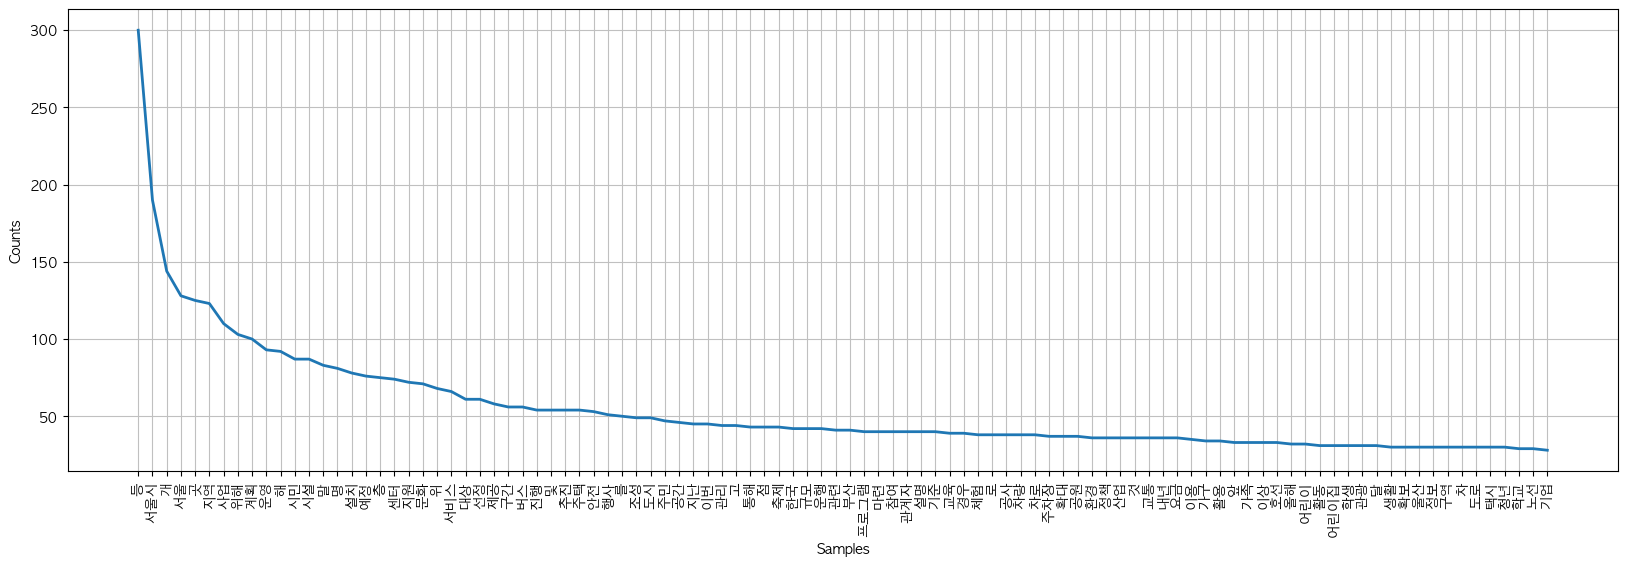

In [ ]:
plt.rcParams["font.family"] = "AppleGothic"
plt.figure(figsize=(20,6))
ko1.plot(100)
plt.show()

In [ ]:
stopwords1 = ['등','개','곳','위해','해','말','명','층','위','및','를','지난','이번','고','통해','점','로',
              '경우','로','것','내년','앞','이상','올해','달']
filtered1 = [word1 for word1 in ko1 if word1 not in stopwords1]
filtered1[0]

'문화'

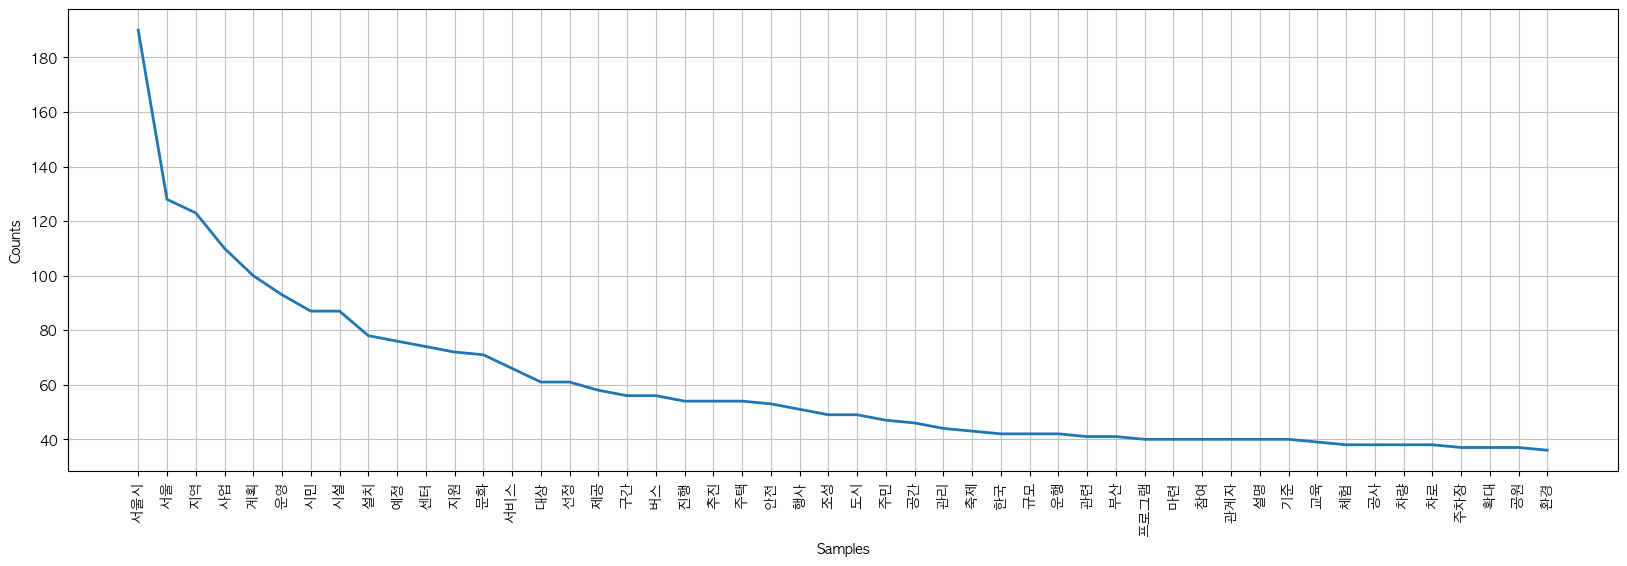

In [ ]:
filtered1 = nltk.Text(filtered1)
plt.rcParams["font.family"] = "AppleGothic"
plt.figure(figsize=(20,6))
filtered1.plot(50)
plt.show()

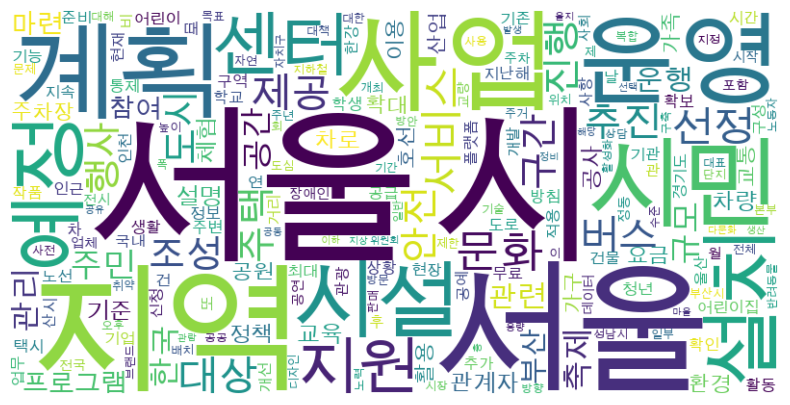

In [ ]:
#군집1 워드클라우드 test
data1 = filtered1.vocab().most_common(200)
wordcloud = WordCloud(font_path='/Library/Fonts/Arial Unicode.ttf', width=800, height=400, background_color="white").generate_from_frequencies(dict(data1))

rc('font', family='Arial Unicode')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

/Users/yurim/Library/Python/3.9/lib/python/site-packages/konlpy/tag/_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


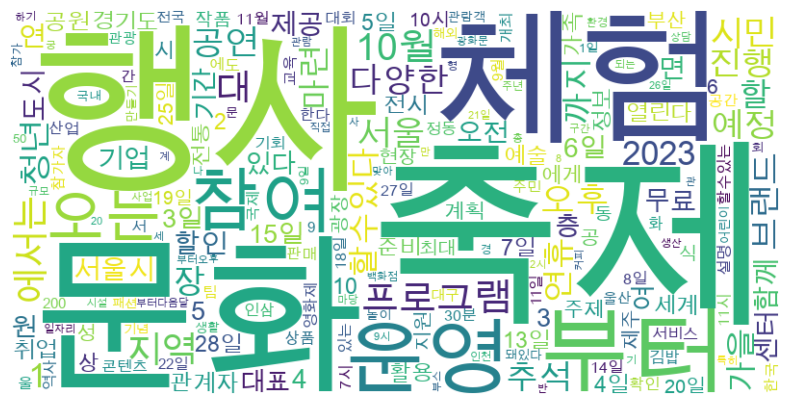

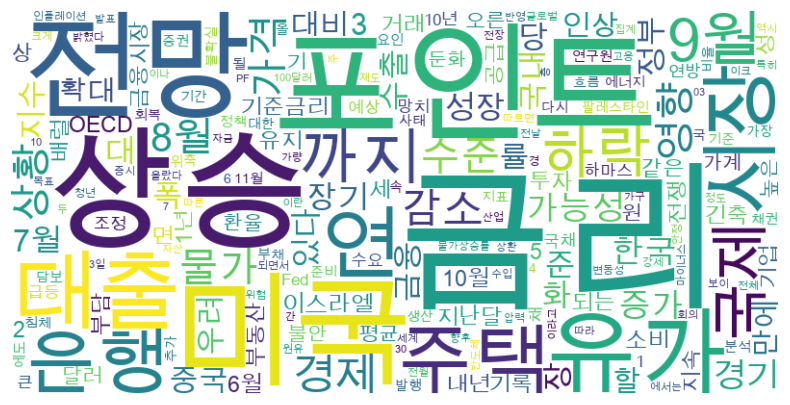

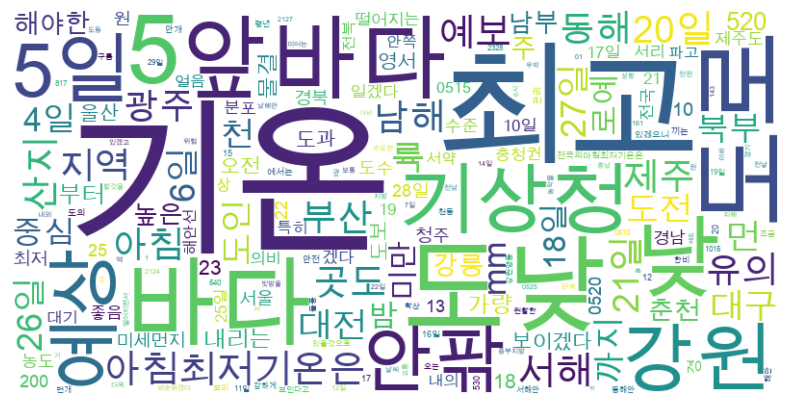

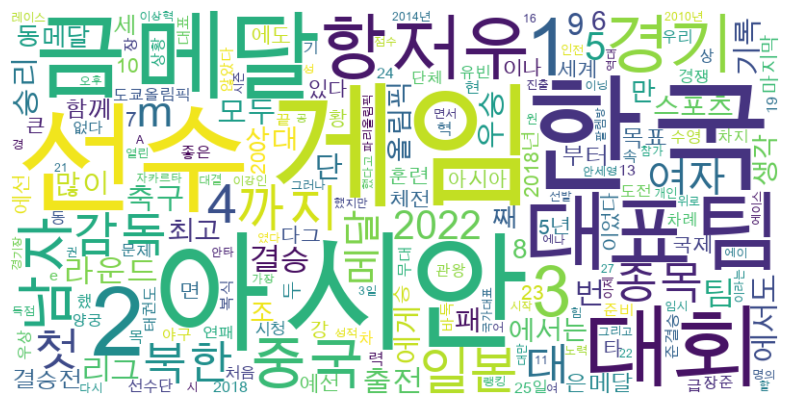

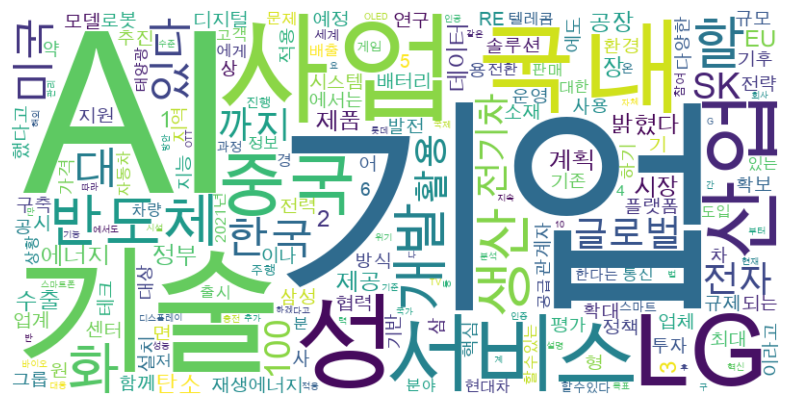

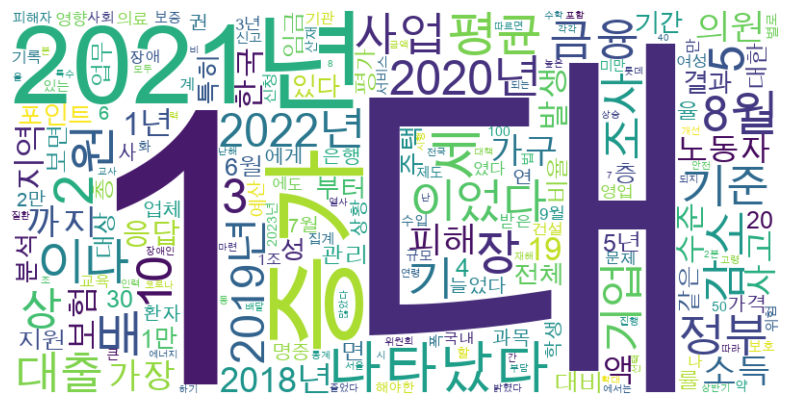

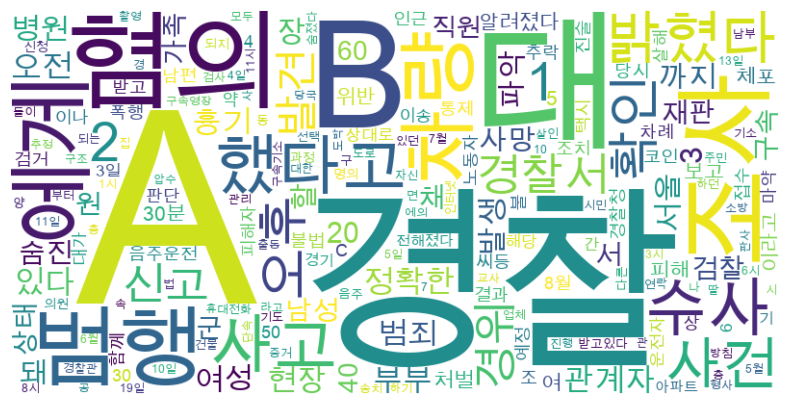

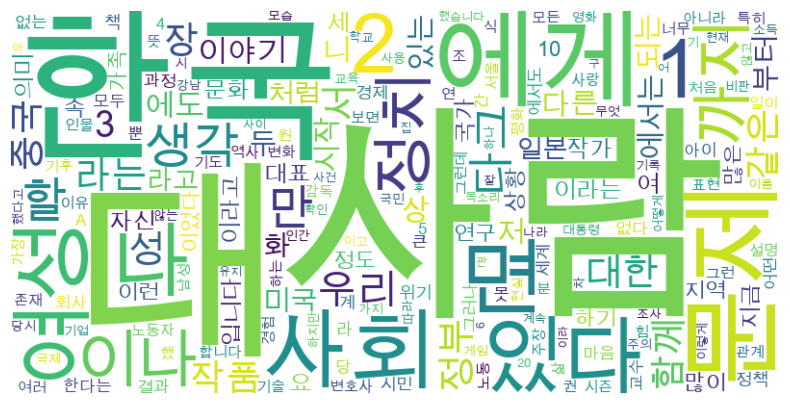

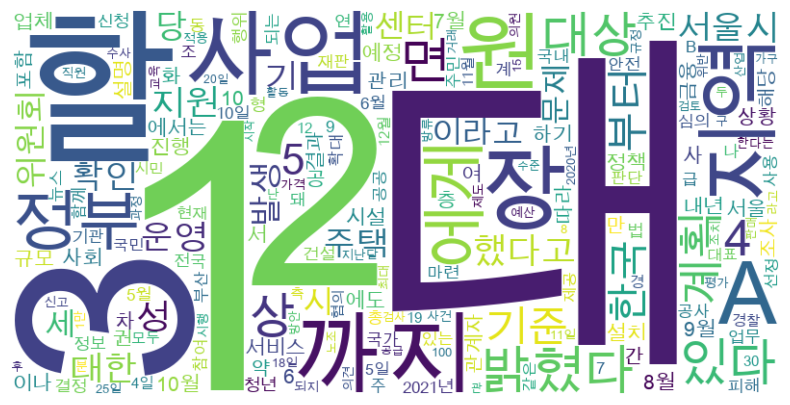

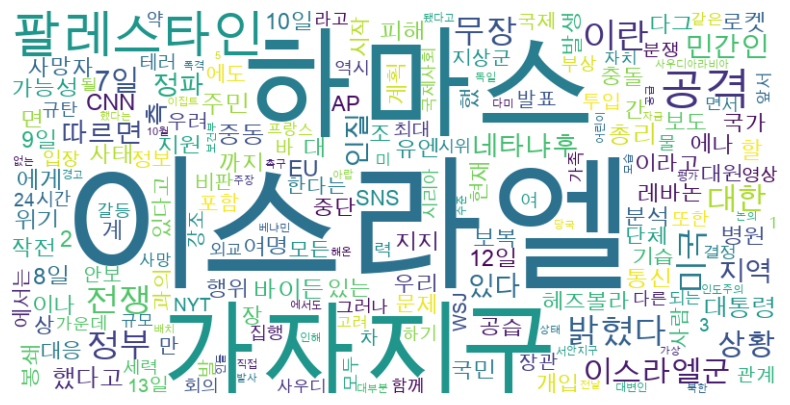

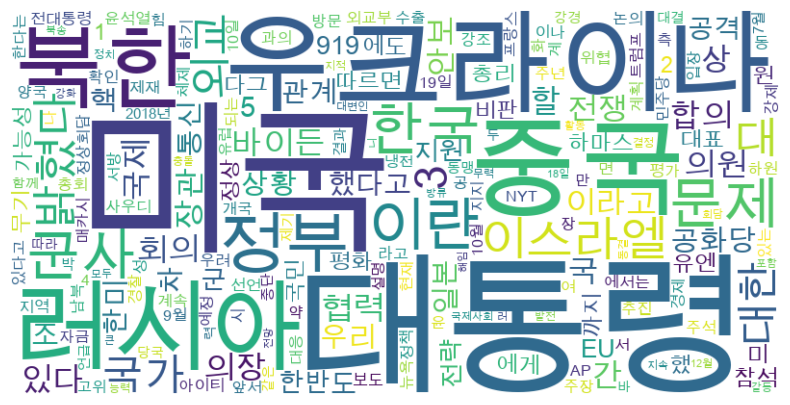

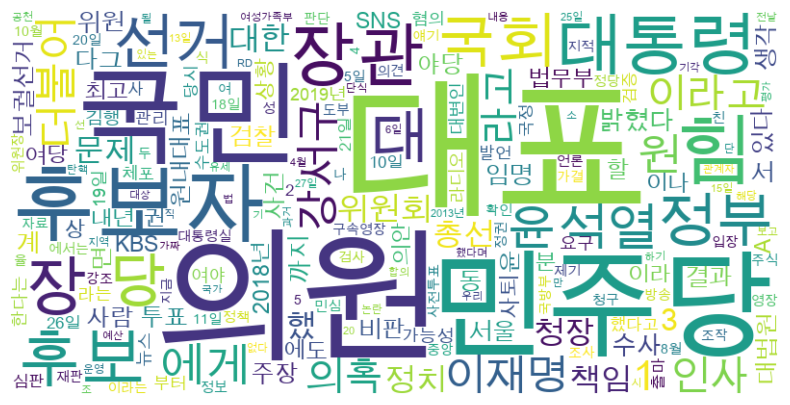

In [ ]:
#군집별 워드클라우드
from konlpy.tag import Twitter
import re
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib import rc

custom_stopwords = ['것','등','이','수','고','말','명','지난','전','그','며','중','위','를','날','개'
    ,'위해','대해','이번','건','의','이후','더','때','관련','씨','로','통해','점','김','지난해','올해','된'
    ,'라며','안','제','경우','때문','일','곳','내','도','및','달','은','뒤','최근','또','사실','시간','적'
    ,'게','데','과','앞','말','명','이상','지난','이번','을','가','는','에','다','에서','와','으로','하','자'
    ,'m','했다','보다','개월','한','들','하고','와','있겠다','에는','에서','이다','해','됐다','된다','인','지']

twitter = Twitter()

for result_value in range(0, 12):
    filtered_rows = cluster_result[cluster_result['result2'] == result_value]

    top_content_list = [re.sub(r'[^\w]', '', content) for content in filtered_rows['top_content']]

    all_top_content = " ".join(top_content_list)

    tokens = twitter.morphs(all_top_content)

    filtered_words = [word for word in tokens if word not in custom_stopwords]

    data = nltk.Text(filtered_words).vocab().most_common(200)
    wordcloud = WordCloud(font_path='/Library/Fonts/Arial Unicode.ttf', width=800, height=400, background_color="white").generate_from_frequencies(dict(data))

    rc('font', family='Arial Unicode')
    plt.rcParams['axes.unicode_minus'] = False
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()